## Section 1: QKeras

In [16]:
# Switching for colab
%tensorflow_version 1.x

In [17]:
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, Adamax

from qkeras import QDense, QActivation, binary, quantized_bits

import os
import matplotlib.pyplot as plt
import numpy as np

In [5]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train / 255.0
    x_test = x_test / 255.0

    B_train = x_train.shape[0]
    B_test = x_test.shape[0]

    x_train = x_train.reshape(x_train.shape + (1,))
    x_test = x_test.reshape(x_test.shape + (1,))

    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)

    y_train = y_train + np.random.uniform(0.0, 0.02, y_train.shape)
    y_train = y_train / np.sum(y_train, axis=1, keepdims=True)
    
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)
    
    return x_train, y_train, x_test, y_test

In [6]:
def get_model(verbose=True):
    x = x_i = Input((784,), name="input")
    x = Dense(300, name="d1")(x)
    x = Activation("relu", name="relu1")(x)
    x = Dense(100, name="d2")(x)
    x = Activation("relu", name="relu2")(x)
    x = Dense(10, name="d3")(x)
    x = Activation("softmax", name="softmax")(x)
    
    model = Model(inputs=x_i, outputs=x)

    if verbose:
        model.summary();
    
    return model

In [8]:
def get_model_q(alphas, verbose=True):
    x = x_i = Input((784,), name="input")
    x = QDense(300, name="d1",
               kernel_quantizer=binary(alpha=alphas.pop(0)),
               bias_quantizer=quantized_bits(4,2,1))(x)
    x = QActivation("binary()", name="act1")(x)
    x = QDense(100, name="d2",
               kernel_quantizer=binary(alpha=alphas.pop(0)),
               bias_quantizer=quantized_bits(4,2,1))(x)
    x = QActivation("binary()", name="act2")(x)
    x = QDense(10, name="d3",
               kernel_quantizer=binary(alpha=alphas.pop(0)),
               bias_quantizer=quantized_bits(4,2,1))(x)
    x = Activation("softmax", name="softmax")(x)
    
    model = Model(inputs=x_i, outputs=x)

    if verbose:
        model.summary();
    
    return model

In [9]:
def train(data, verbose=True):
    x_train, y_train, x_test, y_test = data
    weight_file_name = "elen521-lab6.hdf5"
    model = get_model(verbose=verbose)
    optimizer = Adam(0.01)

    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["acc"])
    
    if os.path.exists(weight_file_name):
        model.load_weights(weight_file_name)
    else:
        history = model.fit(
            x_train, y_train,
            batch_size=64,
            epochs=5,
            validation_split=0.05,
            verbose=True,
            shuffle=True)
        model.save_weights(weight_file_name)
    
    eval_res = model.evaluate(x_test, y_test)
    if verbose:
        print(eval_res)
    
    return eval_res, model

In [10]:
def get_alpha(model):
    layers_with_weights = ["d1", "d2", "d3"]
    alphas = []

    for layer in model.layers:
        if layer.name in layers_with_weights:
            weight_and_bias = layer.get_weights()
            weight = weight_and_bias[0]
            alphas.append(np.mean(np.abs(weight)))

    return alphas

In [11]:
def train_q(data, alphas, verbose=True):
    x_train, y_train, x_test, y_test = data
    model = get_model_q(alphas, verbose=verbose)
    optimizer = Adamax(0.02, beta_1=0.9, beta_2=0.999)

    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["acc"])

    history = model.fit(
        x_train, y_train,
        batch_size=64,
        epochs=5,
        validation_split=0.05,
        verbose=True,
        shuffle=True)
    
    eval_res = model.evaluate(x_test, y_test)
    if verbose:
        print(eval_res)
    
    return eval_res, model


In [12]:
def main():
    data = load_data()
    eval_res, model = train(data)
    
    alphas = get_alpha(model)
    eval_res_q = train_q(data, alphas)

In [13]:
main()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
d1 (Dense)                   (None, 300)               235500    
_________________________________________________________________
relu1 (Activation)           (None, 300)               0         
_________________________________________________________________
d2 (Dense)                   (None, 100)               30100     
_________________________________________________________________
relu2 (Activation)           (None, 100)               0         
_________________________________________________________________
d3 (Dense)                   (None, 10)                1010      
______________________________________________

## Section 2 + 3: Neural Style Transfer

In [16]:
# Switching for colab
%tensorflow_version 2.x

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import time

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array
from tensorflow.keras import applications
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from scipy.optimize import fmin_l_bfgs_b

In [2]:
content_path = 'images/1.jpg'
style_path = 'styles/2.jpg'

In [3]:
content_img = load_img(content_path)
style_img = load_img(style_path)

### Visualize the images

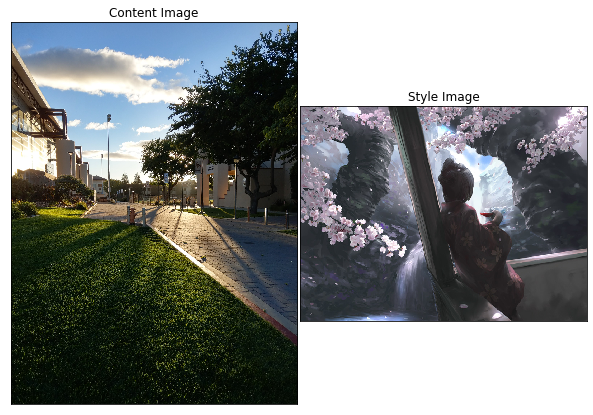

In [4]:
fig = plt.figure(figsize=(8, 6))
fig.subplots_adjust(hspace=0.02, wspace=0.01,
                left=0, right=1, bottom=0, top=1)

ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])        
ax.imshow(content_img)
ax.set_title("Content Image")

ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[]) 
ax.imshow(style_img)
ax.set_title("Style Image")
plt.show()

### Prepare

Global Variables

In [5]:
width, height = content_img.size

img_nrows = width # or hardcode here
img_ncols = height if width == img_nrows else \
    int(width * img_nrows / height)

In [6]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

n_content_layers = len(content_layers)
n_style_layers = len(style_layers)

Utilities

In [7]:
def preprocess_and_load_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = applications.vgg19.preprocess_input(img)
    return img

In [8]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                               "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")
  
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
        
    # Remove zero-center by mean pixel, which is from ImageNet
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

### Loss functions

In [9]:
def get_content_loss(content, combination):
    return tf.reduce_mean(tf.square(content - combination))

In [10]:
def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def get_style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [11]:
def get_total_variation_loss(x):
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':
        a = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
        b = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    else:
        a = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
        b = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

### Model and feature definition

In [12]:
def get_model():
    # build the VGG19 network with our 3 images as input
    # the model will be loaded with pre-trained ImageNet weights
    model = applications.vgg19.VGG19(weights='imagenet', include_top=False)
    model.trainable = False
    print('Model loaded.')
    
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
    
    # Get the style and content feature representations from our model  
    style_outputs   = [outputs_dict[layer_name] for layer_name in style_layers]
    content_outputs = [outputs_dict[layer_name] for layer_name in content_layers]
    
    model_outputs = style_outputs + content_outputs

    return Model(model.input, model_outputs)

In [13]:
def get_feature_representations(model, content_path, style_path):
    # Load images in 
    content_image = preprocess_and_load_image(content_path)
    style_image   = preprocess_and_load_image(style_path)
  
    # Batch compute content and style features
    style_outputs   = model(style_image)
    content_outputs = model(content_image)
  
    # Get the style and content feature representations from our model  
    style_features   = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    return style_features, content_features

In [98]:
# def get_feature_representations(input_tensor):
#     # build the VGG19 network with our 3 images as input
#     # the model will be loaded with pre-trained ImageNet weights
#     model = applications.vgg19.VGG19(input_tensor=input_tensor,
#                         weights='imagenet', include_top=False)
#     model.trainable = False
#     print('Model loaded.')

#     # get the symbolic outputs of each "key" layer (we gave them unique names).
#     outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
    
#     # Get the style and content feature representations from our model  
#     style_features = [outputs_dict[layer_name] for layer_name in style_layers]
#     content_features = [outputs_dict[layer_name] for layer_name in content_layers]

#     return style_features, content_features

In [99]:
# def get_model():
#     # build the VGG19 network with our 3 images as input
#     # the model will be loaded with pre-trained ImageNet weights
#     model = applications.vgg19.VGG19(input_tensor=input_tensor,
#                         weights='imagenet', include_top=False)
#     model.trainable = False
#     print('Model loaded.')
    
#     # get the symbolic outputs of each "key" layer (we gave them unique names).
#     outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
    
#     # Get the style and content feature representations from our model  
#     style_outputs = [outputs_dict[layer_name] for layer_name in style_layers]
#     content_outputs = [outputs_dict[layer_name] for layer_name in content_layers]
    
#     model_outputs = style_outputs + content_outputs

#     return Model(vgg.input, model_outputs)

### Computing the loss and gradients

In [105]:
# def compute_loss(all_features, weights, combination_img):
#     style_features_combination, content_features_combination = all_features
#     content_weight, style_weight, total_variation_weight = weights
    
#     # Combine these loss functions into a single scalar
#     loss = K.variable(0.0)
    
#     # Loss for content
#     for features in content_features_combination:
#         content_features     = features[0, :, :, :]
#         combination_features = features[2, :, :, :]
#         cl = get_content_loss(content_features, combination_features)
#         loss = loss + (content_weight / len(content_features_combination)) * cl
#     # Loss for style
#     for features in style_features_combination:
#         style_features       = features[1, :, :, :]
#         combination_features = features[2, :, :, :]
#         sl = get_style_loss(style_features, combination_features)
#         loss = loss + (style_weight / len(style_features_combination)) * sl

#     # Loss for combination
#     loss = loss + total_variation_weight * total_variation_loss(combination_img)

In [94]:
# def get_grads_and_loss_func(loss, combination_img):
#     # get the gradients of the generated image wrt the loss
#     with tf.GradientTape() as tape: 
#         tape.watch(loss)
    
#     # Compute gradients wrt input image
#     grads = tape.gradient(loss, combination_img)

#     outputs = [loss]
#     if isinstance(grads, (list, tuple)):
#         outputs += grads
#     else:
#         outputs.append(grads)

#     return K.function([combination_img], outputs)

In [63]:
# def eval_loss_and_grads(x, f_outputs):
#     if K.image_data_format() == 'channels_first':
#         x = x.reshape((1, 3, img_nrows, img_ncols))
#     else:
#         x = x.reshape((1, img_nrows, img_ncols, 3))

#     outs = f_outputs([x])
#     loss_value = outs[0]
#     if len(outs[1:]) == 1:
#         grad_values = outs[1].flatten().astype('float64')
#     else:
#         grad_values = np.array(outs[1:]).flatten().astype('float64')

#     return loss_value, grad_values

In [14]:
# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

class Evaluator(object):

    def __init__(self, output_func):
        self.loss_value = None
        self.grads_values = None
        self.output_func = output_func

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(
            x,
            self.output_func)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [15]:
def compute_loss(model, weights, features, combination_img):
    content_weight, style_weight, total_variation_weight = weights
    style_features, content_features = features
  
    # Feed our init image through our model. This will give us the content and 
    # style representations at our desired layers. Since we're using eager
    # our model is callable just like any other function!
    model_outputs = model(combination_img)
    
    print(model_outputs)

    style_output_features   = model_outputs[:n_style_layers]
    content_output_features = model_outputs[n_style_layers:]
  
    style_loss   = 0
    content_loss = 0

    # Accumulate style losses from all layers
    # Here, we equally weight each contribution of each loss layer
    weight_per_style_layer = 1.0 / float(n_style_layers)
    for target_style, comb_style in zip(style_features, style_output_features):
        style_loss += weight_per_style_layer * get_style_loss(target_style, comb_style[0])
    
    # Accumulate content losses from all layers 
    weight_per_content_layer = 1.0 / float(n_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_loss += weight_per_content_layer * get_content_loss(target_content, comb_content[0])
  
    loss = total_variation_weight * get_total_variation_loss(combination_img)

    style_loss   *= style_weight
    content_loss *= content_weight

    # Get total loss
    loss += style_loss + content_loss 
    return loss

In [16]:
def compute_grads_and_loss(cfg):
    with tf.GradientTape() as tape: 
        loss = compute_loss(**cfg)
    return tape.gradient(loss, cfg['combination_img']), loss

### Training

In [17]:
# Show result in Jupyter Notebook
import IPython.display

In [18]:
def apply_style_transfer(content_path, style_path,
                         iterations=10,
                         content_weight=1e3,
                         style_weight=1e-2,
                         total_variation_weight=1):
    
    model = get_model() 
    for layer in model.layers:
        layer.trainable = False
    
    weights = (content_weight, style_weight, total_variation_weight)

    features = get_feature_representations(model, content_path, style_path)
    
    opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)
    
    combination_img = preprocess_image(content_path)
    combination_img = tf.Variable(combination_img, dtype=tf.float32)
    
    cfg = {
      'model': model,
      'weights': weights,
      'combination_img': combination_img,
      'features': features,
    }
    
#     # Get tensor representations of our images
#     content_img = tf.Variable(preprocess_and_lod_image(content_path))
#     style_img   = tf.Variable(preprocess_and_lod_image(style_path))

#     if K.image_data_format() == 'channels_first':
#         combination_img = tf.keras.Input(shape=(1, 3, img_nrows, img_ncols))
#     else:
#         combination_img = tf.keras.Input(shape=(1, img_nrows, img_ncols, 3))

#     # Combine the 3 images into a single Keras tensor
# #     input_tensor = K.concatenate([content_img, style_img, combination_img], axis=0)
#     input_tensor = tf.concat([content_img, style_img, combination_img], axis=0)
    
# #     features = get_feature_representations(input_tensor)
    
   

 # #    loss = K.variable(0.0)
    
#     with tf.GradientTape() as tape:
#         features = get_feature_representations(input_tensor)
# #         loss = compute_loss(features, weights, combination_img)
#         print("loss", loss)
#         content_features_combination, style_features_combination = features
    
#         # Loss for content
#         for features in content_features_combination:
#             content_features     = features[0, :, :, :]
#             combination_features = features[2, :, :, :]
#             cl = get_content_loss(content_features, combination_features)
#             loss = loss + (content_weight / len(content_features_combination)) * cl
#         # Loss for style
#         for features in style_features_combination:
#             style_features       = features[1, :, :, :]
#             combination_features = features[2, :, :, :]
#             sl = get_style_loss(style_features, combination_features)
#             loss = loss + (style_weight / len(style_features_combination)) * sl

#         # Loss for combination
#         loss = loss + total_variation_weight * total_variation_loss(combination_img)

#         grads = tape.gradient(loss, combination_img)
        
#     outputs = [loss]
#     if isinstance(grads, (list, tuple)):
#         outputs += grads
#     else:
#         outputs.append(grads)

#     output_func = K.function([combination_img], outputs)
    
#     output_func = get_grads_and_loss_func(loss, combination_img)
#     evaluator = Evaluator(output_func)
    

    # Store our best result
    best_loss, best_img = float('inf'), None
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means 
    
    # For displaying
    display_num_rows = 2
    display_num_cols = 5
    display_interval = num_iterations / (display_num_rows * display_num_cols)
    global_start_time = time.time()
    
    imgs = []
    for i in range(iterations):
        print('Iteration: %d' % i)
        start_time = time.time()
        
        grads, loss = compute_grads_and_loss(cfg)
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(combination_img, min_vals, max_vals)
        combination_img.assign(clipped)

#         x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
#                                          fprime=evaluator.grads, maxfun=20)
        print('Current loss value:', min_val)
        
        if loss < best_loss:
            # Update best loss and best image from total loss. 
            best_loss = loss
            best_img = deprocess_image(x.copy())

        # save current generated image
        img = deprocess_image(combination_img.numpy().copy())
        imgs.append(imgs)
        fname = result_prefix + '_at_iteration_%d.png' % i
        save_img(fname, img)

        end_time = time.time()
        print('Image saved as', fname)
        print('Iteration %d completed in %ds' % (i, end_time - start_time))
        
        if i % display_interval== 0:
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(img))
        
    # Display historical images
    IPython.display.clear_output(wait=True)
    plt.figure(figsize=(14,4))
    for i,img in enumerate(imgs):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])

In [19]:
apply_style_transfer(content_path, style_path)

80142336/80134624 [==============================] - 2s 0us/step
Model loaded.


KeyboardInterrupt: 